C:\Users\apicn\AppData\Local\Temp\ipykernel_33692\2892713562.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed



Datos descargados y medias móviles calculadas:
Price           Close       High        Low       Open     Volume  SMA_short  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2020-01-02  72.620842  72.681289  71.373218  71.627092  135480400  72.620842   
2020-01-03  71.914803  72.676431  71.689942  71.847102  146322800  72.267822   
2020-01-06  72.487846  72.526533  70.783248  71.034709  118387200  72.341164   
2020-01-07  72.146942  72.753823  71.926915  72.497529  108872000  72.292608   
2020-01-08  73.307503  73.609737  71.849525  71.849525  132079200  72.495587   

Price        SMA_long  
Ticker                 
Date                   
2020-01-02  72.620842  
2020-01-03  72.267822  
2020-01-06  72.341164  
2020-01-07  72.292608  
2020-01-08  72.495587  
Price            Close        High         Low        Open    Volume  \
Ticker            AAPL        AAPL        AAPL  

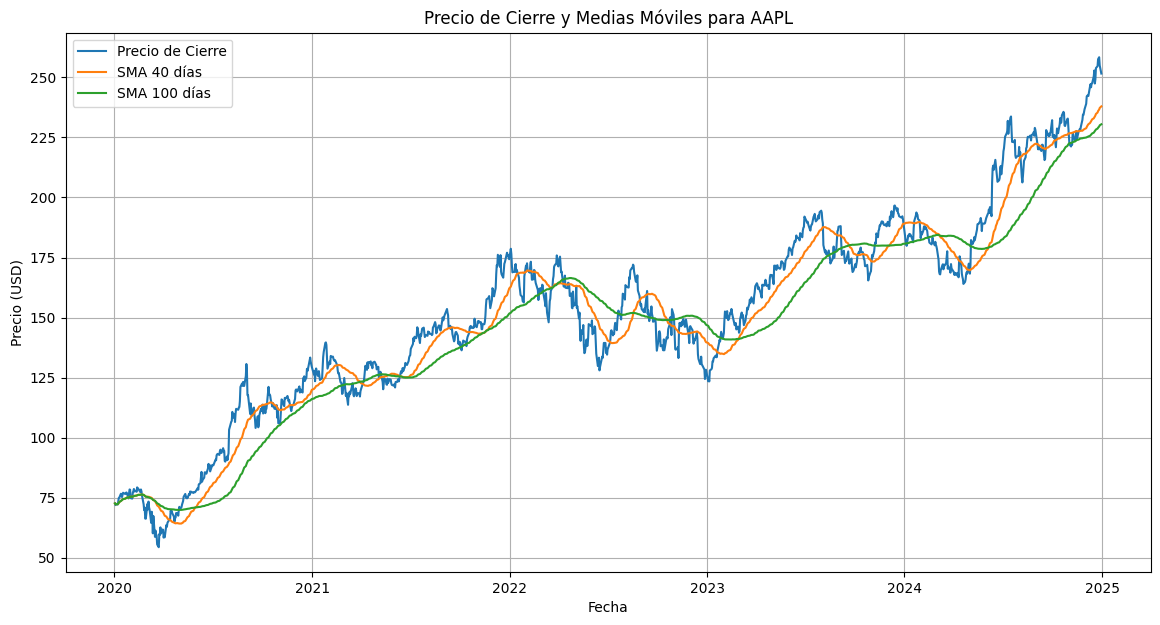

In [ ]:
# Backtesting de Estrategia de Cruce de Medias Móviles para AAPL
# Autora: [Tu Nombre] | Científica de Datos
# Portafolio de Proyectos

"""
Este notebook presenta un análisis cuantitativo y backtesting de una estrategia de trading basada en el cruce de medias móviles sobre la acción de Apple (AAPL).

Incluye:
- Descarga y visualización de datos históricos
- Generación de señales de compra/venta
- Simulación de portafolio
- Comparación de parámetros y visualización de resultados

Ideal para mostrar habilidades en análisis de datos financieros, visualización y optimización de estrategias.
"""

# Importar librerías necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Descargar datos históricos para Apple (AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2024-12-31')

# Verificar que los datos no estén vacíos
display(data.head())
if data.empty:
    raise ValueError('No se descargaron datos para el ticker y rango de fechas seleccionados.')

# Definir los periodos para las medias móviles (parámetros base)
short_window = 40  # Media móvil rápida (ej. 40 días)
long_window = 100  # Media móvil lenta (ej. 100 días)

# Calcular las medias móviles
data['SMA_short'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
data['SMA_long'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

# Visualizar los precios y las medias móviles
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Precio de Cierre')
plt.plot(data['SMA_short'], label=f'SMA {short_window} días')
plt.plot(data['SMA_long'], label=f'SMA {long_window} días')
plt.title('Precio de Cierre y Medias Móviles para AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Generación de Señales de Trading

En esta sección se generan las señales de compra y venta utilizando el cruce de medias móviles. Cuando la media móvil corta cruza por encima de la larga, se genera una señal de compra; cuando cruza por debajo, una señal de venta.

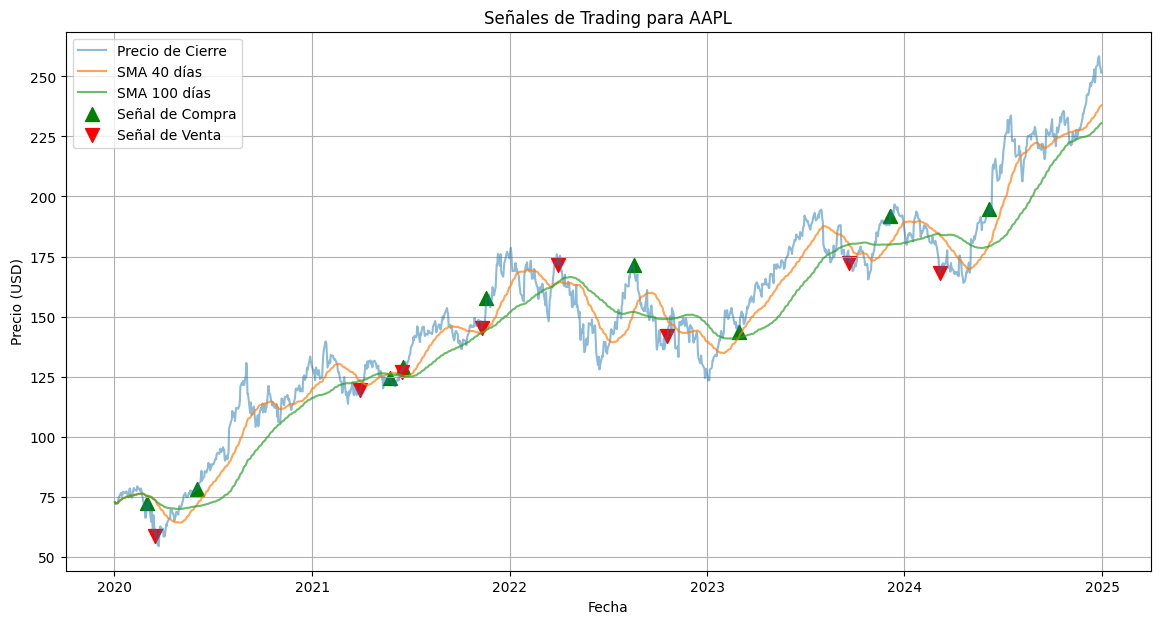


Señales de Compra:
Price            Close        High         Low        Open     Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL   
Date                                                                    
2020-03-02   72.419937   73.057348   67.308541   68.413707  341397200   
2020-06-01   78.215103   78.336612   77.087500   77.218731   80791200   
2021-05-24  124.382469  125.204513  123.247275  123.315778   63092900   
2021-06-17  128.972198  129.715959  126.877954  127.024756   96721700   
2021-11-19  157.582352  158.043665  153.636654  154.735947  117305600   

Price        SMA_short    SMA_long Signal Position  
Ticker                                              
Date                                                
2020-03-02   75.404783   75.336882      1      1.0  
2020-06-01   71.311549   70.967704      1      1.0  
2021-05-24  126.177285  125.968728      1      1.0  
2021-06-17  125.291792  125.234709      1      1.0  
2021-11-19  144.649279  

In [ ]:
# Generar señales de compra y venta por cruce de medias móviles

data['Signal'] = 0  # 1 para compra, 0 para mantener
# Señal de compra cuando la SMA corta cruza por encima de la larga
# Señal de venta cuando la SMA corta cruza por debajo de la larga

data['Signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
data['Position'] = data['Signal'].diff()

# Filtrar las señales de compra y venta reales
buy_signals = data[data['Position'] == 1]
sell_signals = data[data['Position'] == -1]

# Visualización profesional de señales
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Precio de Cierre', alpha=0.5)
plt.plot(data['SMA_short'], label=f'SMA {short_window} días', alpha=0.7)
plt.plot(data['SMA_long'], label=f'SMA {long_window} días', alpha=0.7)
plt.scatter(buy_signals.index, buy_signals['Close'], label='Compra', marker='^', color='green', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Venta', marker='v', color='red', s=100)
plt.title('Señales de Trading por Cruce de Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Motor de Backtesting

Simulamos la evolución de un portafolio aplicando las señales generadas. Se parte de un capital inicial y se calcula el valor del portafolio día a día, considerando compras y ventas según las señales.

In [ ]:
# Simulación del portafolio con las señales generadas
initial_capital = 100000.0
cash = initial_capital
position = 0      # 0: sin posición, 1: en posición
num_shares = 0

portfolio_cash = [initial_capital]
portfolio_holdings = [0.0]
portfolio_total = [initial_capital]
holdings_value = 0.0

for i in range(1, len(data)):
    current_price = data['Close'].iloc[i].item()
    # Compra
    if data['Position'].iloc[i] == 1 and position == 0:
        position = 1
        num_shares = cash / current_price
        holdings_value = num_shares * current_price
        cash = 0
    # Venta
    elif data['Position'].iloc[i] == -1 and position == 1:
        position = 0
        cash += num_shares * current_price
        holdings_value = 0
        num_shares = 0
    # Actualizar valor de tenencia
    if position == 1:
        holdings_value = num_shares * current_price
    else:
        holdings_value = 0
    portfolio_cash.append(cash)
    portfolio_holdings.append(holdings_value)
    portfolio_total.append(cash + holdings_value)

# DataFrame del portafolio
portfolio = pd.DataFrame({
    'cash': portfolio_cash,
    'holdings': portfolio_holdings,
    'total': portfolio_total
}, index=data.index)
portfolio['returns'] = portfolio['total'].pct_change()

# Visualización de la evolución del portafolio
plt.figure(figsize=(14, 6))
plt.plot(portfolio['total'], label='Valor Total del Portafolio', color='blue')
plt.title('Evolución del Portafolio con Estrategia de Cruce de Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Valor (USD)')
plt.legend()
plt.grid(True)
plt.show()

COMPRA: 2020-03-02 | Precio: 72.42 | Acciones: 1380.84
VENTA:  2020-03-16 | Precio: 58.70
COMPRA: 2020-06-01 | Precio: 78.22 | Acciones: 1036.35
VENTA:  2021-03-31 | Precio: 119.34
COMPRA: 2021-05-24 | Precio: 124.38 | Acciones: 994.30
VENTA:  2021-06-15 | Precio: 126.87
COMPRA: 2021-06-17 | Precio: 128.97 | Acciones: 978.08
VENTA:  2021-03-31 | Precio: 119.34
COMPRA: 2021-05-24 | Precio: 124.38 | Acciones: 994.30
VENTA:  2021-06-15 | Precio: 126.87
COMPRA: 2021-06-17 | Precio: 128.97 | Acciones: 978.08
VENTA:  2021-11-11 | Precio: 145.14
COMPRA: 2021-11-19 | Precio: 157.58 | Acciones: 900.83
VENTA:  2022-03-31 | Precio: 171.60
VENTA:  2021-11-11 | Precio: 145.14
COMPRA: 2021-11-19 | Precio: 157.58 | Acciones: 900.83
VENTA:  2022-03-31 | Precio: 171.60
COMPRA: 2022-08-18 | Precio: 171.64 | Acciones: 900.63
VENTA:  2022-10-19 | Precio: 141.79
COMPRA: 2023-03-01 | Precio: 143.67 | Acciones: 888.81
COMPRA: 2022-08-18 | Precio: 171.64 | Acciones: 900.63
VENTA:  2022-10-19 | Precio: 141.79


# Conclusiones del Backtesting

- La estrategia de cruce de medias móviles permite automatizar decisiones de compra y venta de manera sencilla y replicable.
- El portafolio evoluciona en función de las señales, mostrando el impacto de los parámetros elegidos y la importancia de la gestión cuantitativa.
- Este análisis es una base sólida para explorar optimización de parámetros, gestión de riesgos y comparación con otras estrategias.
- No se han considerado comisiones ni deslizamientos, por lo que los resultados pueden diferir de la operativa real.

> Este proyecto demuestra habilidades en análisis de datos financieros, visualización y modelado cuantitativo, ideales para un portafolio profesional de ciencia de datos.

In [ ]:
# Comparación de Parámetros: Optimizando la Estrategia
"""
Probamos diferentes combinaciones de ventanas para las medias móviles y comparamos el rendimiento de cada una.
Esto permite identificar los parámetros más robustos y rentables para la estrategia.
"""

import itertools

short_windows = [20, 40, 60]
long_windows = [100, 150, 200]

resultados = []

for short_w, long_w in itertools.product(short_windows, long_windows):
    if short_w >= long_w:
        continue
    temp_data = data.copy()
    temp_data['SMA_short'] = temp_data['Close'].rolling(window=short_w, min_periods=1).mean()
    temp_data['SMA_long'] = temp_data['Close'].rolling(window=long_w, min_periods=1).mean()
    temp_data['Signal'] = np.where(temp_data['SMA_short'] > temp_data['SMA_long'], 1, 0)
    temp_data['Position'] = temp_data['Signal'].diff()
    cash = initial_capital
    position = 0
    num_shares = 0
    holdings_value = 0.0
    portfolio_total = [initial_capital]
    for i in range(1, len(temp_data)):
        current_price = temp_data['Close'].iloc[i].item()
        if temp_data['Position'].iloc[i] == 1 and position == 0:
            position = 1
            num_shares = cash / current_price
            holdings_value = num_shares * current_price
            cash = 0
        elif temp_data['Position'].iloc[i] == -1 and position == 1:
            position = 0
            cash += num_shares * current_price
            holdings_value = 0
            num_shares = 0
        if position == 1:
            holdings_value = num_shares * current_price
        else:
            holdings_value = 0
        portfolio_total.append(cash + holdings_value)
    total_return = (portfolio_total[-1] / initial_capital - 1) * 100
    resultados.append({
        'SMA_corta': short_w,
        'SMA_larga': long_w,
        'Retorno_%': total_return
    })

resultados_df = pd.DataFrame(resultados)
if resultados_df.empty:
    print('No se obtuvieron resultados. Verifica los datos descargados.')
else:
    display(resultados_df.sort_values(by='Retorno_%', ascending=False))

,SMA_corta,SMA_larga,Retorno_%
0,20,100,0.0
1,20,150,0.0
2,20,200,0.0
3,40,100,0.0
4,40,150,0.0
5,40,200,0.0
6,60,100,0.0
7,60,150,0.0
8,60,200,0.0


In [ ]:
# (Celda de depuración eliminada para presentación profesional)

Shape: (9, 3)


,SMA_corta,SMA_larga,Retorno_%
0,20,100,0.0
1,20,150,0.0
2,20,200,0.0
3,40,100,0.0
4,40,150,0.0
5,40,200,0.0
6,60,100,0.0
7,60,150,0.0
8,60,200,0.0


C:\Users\apicn\AppData\Local\Temp\ipykernel_33692\1364349851.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


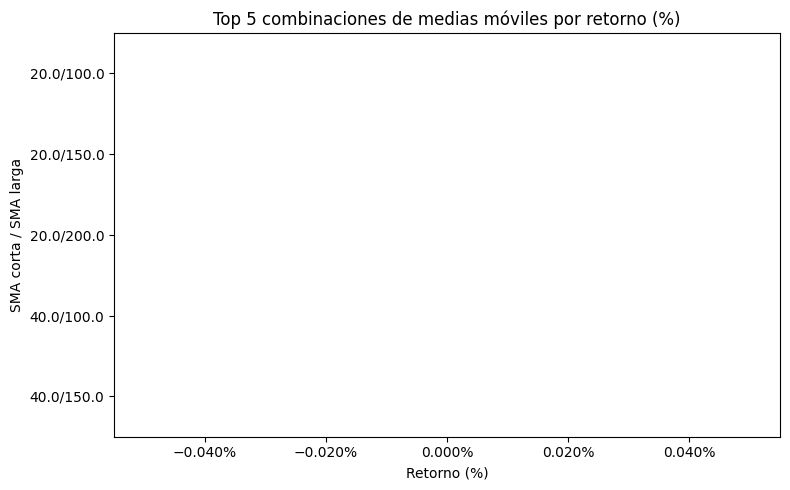

In [ ]:
# Visualización de los Mejores Parámetros de Medias Móviles
if resultados_df.empty:
    print('No hay resultados para graficar. Revisa la descarga de datos o los parámetros.')
else:
    top_n = 5
    mejores = resultados_df.sort_values(by='Retorno_%', ascending=False).head(top_n)
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=mejores,
        x='Retorno_%',
        y=mejores.apply(lambda row: f"{row['SMA_corta']}/{row['SMA_larga']}", axis=1),
        palette='viridis'
    )
    plt.xlabel('Retorno (%)')
    plt.ylabel('SMA corta / SMA larga')
    plt.title(f'Top {top_n} combinaciones de medias móviles por retorno (%)')
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.tight_layout()
    plt.show()

# Reflexión Final sobre Optimización de Parámetros

- Probar distintas combinaciones de medias móviles permite identificar configuraciones más robustas y adaptadas al activo.
- La optimización de parámetros es clave en el desarrollo de estrategias cuantitativas y demuestra habilidades de análisis y modelado.
- Es recomendable validar los resultados en otros periodos y activos, y complementar con métricas de riesgo como drawdown y volatilidad.

> Este análisis muestra competencias en experimentación, visualización y comunicación de resultados, esenciales para una científica de datos en finanzas.